In [1]:
%%capture
!pip install scprep
!pip install anndata
!pip install scanpy

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scprep
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
import tempfile
import os
import sys
import scipy
from scipy import sparse

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import load_raw
import normalize_tools as nm
import metrics

# **try out with scicar cell lines dataset**

In [3]:
input_train_mod1 = ad.read_h5ad("./multiome/multiome_gex_processed_training.h5ad")
input_train_mod2 = ad.read_h5ad("./multiome/multiome_atac_processed_training.h5ad")

In [4]:
#print(input_train_mod1.obs)
#print(input_train_mod2.obs)
print(input_train_mod1.X.shape)
print(input_train_mod2.X.shape)

(20952, 15037)
(20952, 119014)


In [5]:
def clip(adata, prop_clip=0.5):
    assert isinstance(prop_clip, float) and 0.0 < prop_clip < 50.0
    clip_low, clip_high = np.percentile(adata.X.flatten(), [prop_clip, 100 - prop_clip])
    adata.X = np.clip(adata.X, clip_low, clip_high)

In [6]:
#filter ATAC data to reduce the dimensionality
nm.filter_adata(
    input_train_mod2,
    filter_gene_min_counts=5, 
    filter_gene_min_cells=5,
    filter_gene_max_cells=0.005,
)

In [7]:
print(input_train_mod2.X.shape)

(20952, 32685)


In [8]:
## how about doing PCA transformation 


In [11]:
#train test spliting, get train cell indices and test cell mask
def split_indices(n_obs, train_prop=0.8):
    n_train = int(n_obs * train_prop)
    n_test = n_obs - n_train
    train_cells = np.random.choice(n_obs, n_train, replace=False)
    test_mask = np.isin(np.arange(n_obs), train_cells, invert=True)
    return train_cells, test_mask

In [12]:
assert input_train_mod1.X.shape[0] == input_train_mod2.X.shape[0]
train_cells, test_mask = split_indices(input_train_mod1.X.shape[0])
train_mod1, test_mod1 = load_raw.split_mask_single(input_train_mod1, train_cells, test_mask)
train_mod1, test_mod2 = load_raw.split_mask_single(input_train_mod2, train_cells, test_mask)

In [15]:
print(test_mod1.X.shape)

(6286, 15037)


# **define pytorch datasets for RNA and ATAC**

In [16]:
class Merge_Dataset(Dataset):
    def __init__(self, data_mod1, data_mod2):
        self.gex_data = self._load_data(data_mod1)
        self.atac_data = self._load_data(data_mod2)
        
    def __len__(self):
        #assert(len(self.rna_data) == len(self.atac_data))
        return len(self.gex_data)
  
    def __getitem__(self, idx):
        gex_sample = self.gex_data.values[idx]
        atac_sample = self.atac_data.values[idx]
        
        return torch.from_numpy(gex_sample).float(), torch.from_numpy(atac_sample).float(),
        
    
    def _load_data(self, adata):
        df = pd.DataFrame(
            data = adata.X.toarray(), 
            index = np.array(adata.obs.index), 
            columns = np.array(adata.var.index),
        )
        return df

# **Compute DCCA loss (-corr(H1, H2))**



In [10]:
class cca_loss():
    def __init__(self, out_dim, device, use_all_singvals=False):
        self.out_dim = out_dim #parameter o in original paper
        self.use_all_singvals = use_all_singvals
        self.device = device
  
    def loss(self, H1, H2):
        r1 = 1e-3
        r2 = 1e-3
        eps = 1e-9

        #transpose H1, H2: m x o -> o x m
        H1 = H1.t()
        H2 = H2.t()
        #assert torch.isnan(H1).sum().item() == 0
        #assert torch.isnan(H2).sum().item() == 0

        m = H1.size(1)
        o1, o2 = H1.size(0), H2.size(0)

        #produce the centered data matrices: H1 - 1/m*H1·I (same for H2bar)
        H1bar = H1 - H1.mean(dim=1).unsqueeze(dim=1)
        H2bar = H2 - H2.mean(dim=1).unsqueeze(dim=1)
        assert torch.isnan(H1bar).sum().item() == 0
        assert torch.isnan(H2bar).sum().item() == 0

        SigmaHat12 = (1.0/(m-1))*torch.matmul(H1bar, H2bar.t())
        SigmaHat11 = (1.0/(m-1))*torch.matmul(H1bar, H1bar.t()) + r1*torch.eye(o1, device=self.device)
        SigmaHat22 = (1.0/(m-1))*torch.matmul(H2bar, H2bar.t()) + r2*torch.eye(o2, device=self.device)
        #assert torch.isnan(SigmaHat11).sum().item() == 0
        #assert torch.isnan(SigmaHat12).sum().item() == 0
        #assert torch.isnan(SigmaHat22).sum().item() == 0

        #calculate the root inverse (e.g. SigmaHat11^(-1/2)) using sigular value decomposition
        D1, V1 = torch.symeig(SigmaHat11, eigenvectors=True)
        D2, V2 = torch.symeig(SigmaHat22, eigenvectors=True)

        # ??? probably problemetic in gene count setting
        posIdx1 = torch.gt(D1, eps).nonzero()[:, 0]
        D1 = D1[posIdx1]
        V1 = V1[:, posIdx1]

        posIdx2 = torch.gt(D2, eps).nonzero()[:, 0]
        D2 = D2[posIdx2]
        V2 = V2[:,posIdx2]

        #???take care of torch.sqrt
        SigmaHatRootInv11 = torch.matmul(torch.matmul(V1, torch.diag((D1)**(-0.5))), V1.t())
        SigmaHatRootInv22 = torch.matmul(torch.matmul(V2, torch.diag((D2)**(-0.5))), V2.t())

        #calculate T
        Tval = torch.matmul(torch.matmul(SigmaHatRootInv11, SigmaHat12), SigmaHatRootInv22)

        #calculate corr(H1, H2): matrix trace norm of T or sum of top k singular vals of T
        trace_TT = torch.matmul(Tval.t(), Tval)
        if self.use_all_singvals:
            corr = torch.trace(torch.sqrt(trace_TT))
            #assert torch.isnan(corr).item() == 0
        else:
            trace_TT = torch.add(trace_TT, (torch.eye(trace_TT.shape[0])*r1).to(self.device))
            U, V = torch.symeig(trace_TT, eigenvectors=True)
            U = torch.where(U>eps, U, (torch.ones(U.shape).float()*eps).to(self.device))
            U = U.topk(self.out_dim)[0]
            corr = torch.sum(torch.sqrt(U))
            #print("loss: " + str(-corr))
        return -corr

In [11]:
class StructureHingeLoss(nn.Module):
    def __init__(self, margin, max_val, lamb_match, lamb_nn, device):
        super(StructureHingeLoss, self).__init__()
        self.margin = margin
        self.max_val = max_val
        self.lamb_match = lamb_match
        self.lamb_nn = lamb_nn
        self.device = device
        
    def forward(self, rna_outputs, atac_outputs, nn_indices):
        #rna_outputs: n_batch x n_latent
        #atac_outputs: n_batch x n_latent
        assert rna_outputs.shape[0] == atac_outputs.shape[0]
        assert rna_outputs.shape[1] == atac_outputs.shape[1]
        n_batch = rna_outputs.shape[0]
        
        #calculated pairwise L2 distance
        #dist_rna_atac[i][j]: the L2 distance between RNA embedding i
        #and ATAC embedding j (n_batch x n_batch)
        #constraint for ensuring every rna embedding is close to matched atac embedding
        dist_rna_atac = torch.cdist(rna_outputs, atac_outputs, p=2)
        match_labels = torch.eye(n_batch).to(self.device)
        match_mask = match_labels > 0
        pos_match_dist = torch.masked_select(dist_rna_atac, match_mask).view(n_batch, 1)
        neg_match_dist = torch.masked_select(dist_rna_atac, ~match_mask).view(n_batch, -1)
        
        loss_match_rna = torch.clamp(self.margin + pos_match_dist - neg_match_dist, 0, self.max_val)
        loss_match_rna = loss_match_rna.mean()
        #print(f"loss_match_rna: {loss_match_rna}")
        
        #constraint for ensuring every atac embedding is close to matched rna embedding
        dist_atac_rna = dist_rna_atac.t()
        pos_match_dist = torch.masked_select(dist_atac_rna, match_mask).view(n_batch, 1)
        neg_match_dist = torch.masked_select(dist_atac_rna, ~match_mask).view(n_batch, -1)
        
        loss_match_atac = torch.clamp(self.margin + pos_match_dist - neg_match_dist, 0, self.max_val)
        loss_match_atac = loss_match_rna.mean()
        #print(f"loss_match_atac: {loss_match_atac}")
        
        #constraint for ensuring that every RNA embedding is close to 
        #the neighboring RNA embeddings.
        nn_masked = torch.zeros(n_batch, n_batch).to(self.device)
        nn_masked.scatter_(1, nn_indices, 1.)
        nn_masked = nn_masked > 0
        
        dist_rna_rna = torch.cdist(rna_outputs, rna_outputs, p=2)
        
        #pos_rna_nn_dist: n_batch x n_neighbor
        pos_rna_nn_dist = torch.masked_select(dist_rna_rna, nn_masked).view(n_batch, -1)
        neg_rna_nn_dist = torch.masked_select(dist_rna_rna, ~nn_masked).view(n_batch, -1)
        rna_nn_loss = torch.clamp(self.margin + pos_rna_nn_dist[...,None] - neg_rna_nn_dist[..., None, :], 0, self.max_val)
        rna_nn_loss = rna_nn_loss.mean()
        #print(f"rna_nn_loss: {rna_nn_loss}")
        
        #constraint for ensuring that every ATAC embedding is close to 
        #the neighboring ATAC embeddings.
        dist_atac_atac = torch.cdist(atac_outputs, atac_outputs, p=2)
        #pos_rna_nn_dist: n_batch x n_neighbor
        pos_atac_nn_dist = torch.masked_select(dist_atac_atac, nn_masked).view(n_batch, -1)
        neg_atac_nn_dist = torch.masked_select(dist_atac_atac, ~nn_masked).view(n_batch, -1)
        atac_nn_loss = torch.clamp(self.margin + pos_atac_nn_dist[...,None] - neg_atac_nn_dist[..., None, :], 0, self.max_val)
        atac_nn_loss = atac_nn_loss.mean()
        #print(f"atac_nn_loss: {atac_nn_loss}")
        
        loss = (self.lamb_match * loss_match_rna 
                + self.lamb_match * loss_match_atac
                + self.lamb_nn * rna_nn_loss 
                + self.lamb_nn * atac_nn_loss)
        return loss

# Define Reconstruction Loss Using Decoder for each AE

In [12]:
def recon_loss(x, x_recon, y, y_recon):
    MSE = nn.MSELoss()
    x_loss = MSE(x, x_recon)
    y_loss = MSE(y, y_recon)
    total_loss = x_loss + y_loss
    return total_loss

# **define basic models(now just encoder net) for learning latent space**

In [13]:
class Encoder(nn.Module):
    def __init__(self, n_input, n_latent, layer_sizes):
        super(Encoder, self).__init__()
        self.n_input = n_input
        self.n_latent = n_latent
        self.layer_sizes = [n_input] + layer_sizes + [n_latent]
        self.encoder_layers = []
        
        for idx in range(len(self.layer_sizes) - 1):
            fc1 = nn.Linear(self.layer_sizes[idx], self.layer_sizes[idx + 1])
            nn.init.xavier_uniform_(fc1.weight)
            self.encoder_layers.append(fc1)
            bn1 = nn.BatchNorm1d(self.layer_sizes[idx + 1])
            self.encoder_layers.append(bn1)
            act1 = nn.PReLU()
            self.encoder_layers.append(act1)
            
        self.encoder = nn.Sequential(*self.encoder_layers)
        
    def forward(self, x):
        return(self.encoder(x))

# Assembly Neural Net And Loss Into DCCA Model

In [14]:
class DCCA(nn.Module):
    def __init__(
        self, 
        n_input1, 
        n_input2, 
        layer_sizes1, 
        layer_sizes2, 
        n_out, 
        use_all_singvals=False, 
        device=torch.device("cpu"), 
        use_decode = False, 
        seed=182822,
    ):
        super(DCCA, self).__init__()
        torch.manual_seed(seed)
        self.Net1 = Encoder(n_input1, n_latent=n_out, layer_sizes=layer_sizes1)
        self.Net2 = Encoder(n_input2, n_latent=n_out, layer_sizes=layer_sizes2)
        self.cca_loss = cca_loss(out_dim=n_out, use_all_singvals=use_all_singvals, device=device).loss
        self.recon_loss = recon_loss
        
        self.device = device
        self.use_decode = use_decode
        
    def forward(self, x1, x2):
        z1 = self.Net1(x1)
        embed1 = F.normalize(z1, dim=1, p=2)
        z2 = self.Net2(x2)
        embed2 = F.normalize(z2, dim=1, p=2)
        return embed1, embed2

# **Train Basic Model**

In [15]:
#set up all hyper-parameters
hyper = {
    "nEpochs":100,
    "dim_rna":dim_rna,
    "dim_atac":dim_atac,
    "n_latent":32,
    "layer_sizes":[256, 64],
    "add_hinge":True,
    "lamb_match":1,
    "lamb_nn":1.5,
    "lamb_hinge":10,
    "train_batch":256,
    "test_batch": 512,
    "lr": 1e-3,
    "clip_grad": 1,
    "checkpoint_path": './checkpoint/best_dcca_matching.pt',
}

In [16]:
def collate_fn(batch):
    n_svd = 100
    proportion_neighbors = 0.1
    
    rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw = zip(*batch)
    rna_inputs_filtered = torch.stack(rna_inputs_filtered)
    atac_inputs_filtered = torch.stack(atac_inputs_filtered)
    rna_inputs_raw = torch.stack(rna_inputs_raw)
    
    n_svd = min([n_svd, min(rna_inputs_raw.shape) - 1])
    n_neighbors = int(np.ceil(proportion_neighbors * rna_inputs_raw.shape[0]))
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(rna_inputs_raw)
    _, indices_true = (
        sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X_pca).kneighbors(X_pca)
    )
    
    return rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw, torch.from_numpy(indices_true)

In [17]:
#load dataset and split train and test data
#load dataset and split train and test data
def get_data_loaders(train_data_filtered, test_data_filtered, train_data_raw, test_data_raw):
    train_set = Merge_Dataset(train_data_raw, train_data_filtered)
    test_set = Merge_Dataset(test_data_raw, test_data_filtered)
    #load data loader
    train_loader = DataLoader(
        train_set, 
        batch_size=hyper["train_batch"], 
        collate_fn=collate_fn,
        drop_last=False, 
        shuffle=True,
    )
    test_loader = DataLoader(
        test_set, 
        batch_size=hyper["test_batch"], 
        collate_fn=collate_fn,
        drop_last=False, 
        shuffle=False,
    )
    return train_loader, test_loader

In [18]:
#use GPU if available
my_device = "cuda" if torch.cuda.is_available() else "cpu"

/home/jiayueg/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
def knn_criteria(rna_inputs, rna_outputs, atac_outputs, proportion_neighbors=0.1, n_svd=100):
    n_svd = min([n_svd, min(rna_inputs.shape)-1])
    n_neighbors = int(np.ceil(proportion_neighbors*rna_inputs.shape[0]))
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(rna_inputs)
    _, indices_true = (
        sklearn.neighbors.NearestNeighbors(n_neighbors = n_neighbors).fit(X_pca).kneighbors(X_pca)
    )
    _, indices_pred = (
        sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(rna_outputs).kneighbors(atac_outputs)
    )
    neighbors_match = np.zeros(n_neighbors, dtype=int)
    for i in range(rna_inputs.shape[0]):
        _, pred_matches, true_matches = np.intersect1d(
            indices_pred[i], indices_true[i], return_indices=True
        )
        neighbors_match_idx = np.maximum(pred_matches, true_matches)
        neighbors_match += np.sum(np.arange(n_neighbors) >= neighbors_match_idx[:, None], axis = 0,)
    neighbors_match_curve = neighbors_match/(np.arange(1, n_neighbors + 1) * rna_inputs.shape[0])
    area_under_curve = np.mean(neighbors_match_curve)
    return area_under_curve

In [21]:
#set up train functions
def main():
    #load training data and testing data
    train_loader, test_loader = get_data_loaders(
        train_data_filtered, 
        test_data_filtered,
        train_data_raw,
        test_data_raw,
    )
    
    #load checkpoint
    checkpoint = torch.load(hyper["checkpoint_path"])
    
    #load basic models
    dcca_model = DCCA(
        n_input1=hyper["dim_rna"], 
        n_input2=hyper["dim_atac"], 
        layer_sizes1=hyper["layer_sizes"], 
        layer_sizes2=hyper["layer_sizes"], 
        n_out=hyper["n_latent"],
        use_all_singvals=False,
        device=torch.device(my_device), 
        use_decode = False,
    )
    dcca_model.load_state_dict(checkpoint['model_state_dict'])
    
    #set up optimizer
    dcca_opt = optim.Adam(list(dcca_model.parameters()), lr=hyper["lr"])
    dcca_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        dcca_opt, 
        patience=10,
        factor=0.5,
        threshold=0.3, 
        threshold_mode="abs",
        min_lr=1e-5,
    )
    
    #set up device 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dcca_model.to(device)
    
    #keep track of best knn accuracy on dev set
    best_knn_auc = checkpoint["dev_acc"]
    
    #training step
    for epoch in range(hyper["nEpochs"]):
        train_losses = []
        for idx, (rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw, nn_indices) in enumerate(train_loader):
            dcca_opt.zero_grad()

            rna_inputs_filtered = Variable(rna_inputs_filtered).to(device)
            atac_inputs_filtered = Variable(atac_inputs_filtered).to(device)
            rna_inputs_raw = Variable(rna_inputs_raw).to(device)
            nn_indices = Variable(nn_indices).to(device)
            
            embed_rna, embed_atac = dcca_model(rna_inputs_filtered, atac_inputs_filtered)
            
            #calculate train loss
            train_loss = dcca_model.cca_loss(embed_rna, embed_atac)
            if hyper["add_hinge"]:
                hinge_loss = StructureHingeLoss(
                    margin=0.25, 
                    max_val=1e6, 
                    lamb_match=hyper["lamb_match"], 
                    lamb_nn=hyper["lamb_nn"],
                    device=device,
                )
                h_loss = hinge_loss(embed_rna, embed_atac, nn_indices)
                #train_loss = train_loss + h_loss
                train_loss += hyper['lamb_hinge'] * h_loss
                #print(f"train loss: {train_loss}")
                #print(f"hinge loss: {h_loss}")
                #print(f"train loss with hinge: {train_loss}")
            train_loss.backward()
            #nn.utils.clip_grad_norm_(toy_model.parameters(), max_norm=hyper["clip_grad"])
            dcca_opt.step()
            dcca_scheduler.step(train_loss)
            train_losses.append(train_loss.item())
        avg_train_loss = np.mean(train_losses)
        if epoch % 5 == 0:
            print("Epoch: " + str(epoch) + ", train loss: " + str(avg_train_loss))
        
        #evaluating step
        with torch.no_grad():
            dcca_model.eval()
            knn_acc = []
            #mse_acc = []
            for idx, samples in enumerate(test_loader):
                rna_inputs_filtered = samples[0].float().to(device)
                atac_inputs_filtered = samples[1].float().to(device)
                rna_inputs_raw = samples[2].float().to(device)

                output_rna, output_atac = dcca_model(rna_inputs_filtered, atac_inputs_filtered)
                knn_acc.append(knn_criteria(rna_inputs_raw.cpu().detach(), output_rna.cpu().detach(), output_atac.cpu().detach()))
            avg_knn_auc = np.mean(knn_acc)
            
        #checkpointing to save the model with best knn-auc so far
        if avg_knn_auc > best_knn_auc:
            torch.save({
                "epoch":epoch,
                "lamb_match":hyper["lamb_match"],
                "lamb_nn":hyper["lamb_nn"],
                "lamb_hinge":hyper["lamb_hinge"],
                "clip_grad":hyper['clip_grad'],
                "layer_sizes":hyper['layer_sizes'],
                "model_state_dict":dcca_model.state_dict(),
                "optimizer_state_dict":dcca_opt.state_dict(),
                "train_loss":avg_train_loss,
                "dev_acc":avg_knn_auc,
            }, hyper['checkpoint_path'])
        
        if epoch % 5 == 0:
            print("Epoch: " + str(epoch) + ", acc: " + str(avg_knn_auc))
    test_knn_score, test_mse_score = model_eval(dcca_model, test_data_filtered, test_data_raw, device)
    print("Final knn_auc: " + str(test_knn_score))
    print("Final mse: " + str(test_mse_score))
    return dcca_model

In [22]:
main()

<ipython-input-10-bf0918d449f6>:39: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  posIdx1 = torch.gt(D1, eps).nonzero()[:, 0]


Epoch: 0, train loss: -25.14381687457745
Epoch: 0, acc: 0.3697520338855896
Epoch: 5, train loss: -27.846600459172176
Epoch: 5, acc: 0.39851826340397545
Epoch: 10, train loss: -28.0077144916241
Epoch: 10, acc: 0.3990548058361138
Epoch: 15, train loss: -28.072547619159405
Epoch: 15, acc: 0.3992491976652202
Epoch: 20, train loss: -28.110931103046124
Epoch: 20, acc: 0.3995398718892693
Epoch: 25, train loss: -28.180320006150467
Epoch: 25, acc: 0.4000926345053051
Epoch: 30, train loss: -28.25339552072378
Epoch: 30, acc: 0.4003245550688575
Epoch: 35, train loss: -28.285487688504734
Epoch: 35, acc: 0.40096059158867714
Epoch: 40, train loss: -28.334337087777946
Epoch: 40, acc: 0.4012147344378882
Epoch: 45, train loss: -28.31081903897799
Epoch: 45, acc: 0.40171035783656744
Epoch: 50, train loss: -28.37836001469539
Epoch: 50, acc: 0.40169036414995407
Epoch: 55, train loss: -28.402457750760593
Epoch: 55, acc: 0.4025505866844938
Epoch: 60, train loss: -28.455579170813927
Epoch: 60, acc: 0.402787130

DCCA(
  (Net1): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=60550, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=256, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): PReLU(num_parameters=1)
    )
  )
  (Net2): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=57901, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=256, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, t

In [20]:
def model_eval(model, test_adata_filtered, test_adata_raw, title):
    with torch.no_grad():
        model.cpu()
        model.eval()
        rna_inputs = Variable(torch.from_numpy(test_adata_filtered.X.toarray()).float())
        atac_inputs = Variable(torch.from_numpy(test_adata_filtered.obsm["mode2"].toarray()).float())
        #rna_inputs = rna_inputs.to(device)
        #atac_inputs = atac_inputs.to(device)
        z_rna, z_atac = model(rna_inputs, atac_inputs)
        
    test_adata_raw.obsm["aligned"] = sparse.csr_matrix(z_rna.cpu().detach())
    test_adata_raw.obsm["mode2_aligned"] = sparse.csr_matrix(z_atac.cpu().detach())
    metrics.plot_multimodal_umap(test_adata_raw, title=title, num_points=100, connect_modalities=True)
    knn_score, mse_score = metrics.knn_auc(test_adata_raw), metrics.mse(test_adata_raw)
    return knn_score, mse_score

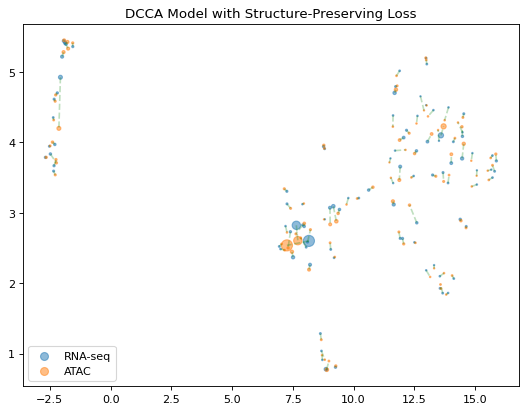

(0.38261566593679375, 0.021450091)

In [23]:
#plot the result and give the evalutation matrics score
checkpoint = torch.load(hyper["checkpoint_path"], map_location="cpu")
dcca_model = DCCA(
        n_input1=hyper["dim_rna"], 
        n_input2=hyper["dim_atac"], 
        layer_sizes1=hyper["layer_sizes"], 
        layer_sizes2=hyper["layer_sizes"], 
        n_out=hyper["n_latent"],
        use_all_singvals=False,
        device=torch.device(my_device), 
        use_decode = False,
    )
dcca_model.load_state_dict(checkpoint['model_state_dict'])
model_eval(
    dcca_model, 
    test_data_filtered, 
    test_data_raw, 
    title = "DCCA Model with Structure-Preserving Loss",
)

In [ ]:
def similairty(model, test_adata_filtered):
    with torch.no_grad():
        model.cpu()
        model.eval()
        rna_inputs = Variable(torch.from_numpy(test_adata_filtered.X.toarray()).float())
        atac_inputs = Varialbe(torch.from_numpy(test_adata_filtered.obsm["mode2"].toarray()).float())
        z_rna, z_atac = model(rna_inputs, atac_inputs)
    cos_score = nn.CosineSimilairty(z_rna, z_atac)
    return(cos_score)